Enter the name of the file: 
'CV-point 1'-C_1
Enter the Scan Rate 
0.1
Do you want to upload more files? 
1
Enter the name of the file: 
'CV-point 2'-C_1
Enter the Scan Rate 
0.2
Do you want to upload more files? 
1
Enter the name of the file: 
'CV-point 3'-C_1
Enter the Scan Rate 
0.3
Do you want to upload more files? 
1
Enter the name of the file: 
CV-point 5'-C_1
Enter the Scan Rate 
0.5
Do you want to upload more files? 
1
Enter the name of the file: 
CV-point 7'-C_1
Enter the Scan Rate 
0.7
Do you want to upload more files? 
1
Enter the name of the file: 
CV-point 9'-C_1
Enter the Scan Rate 
0.9
Do you want to upload more files? 
0
Name of the Output File: 
out


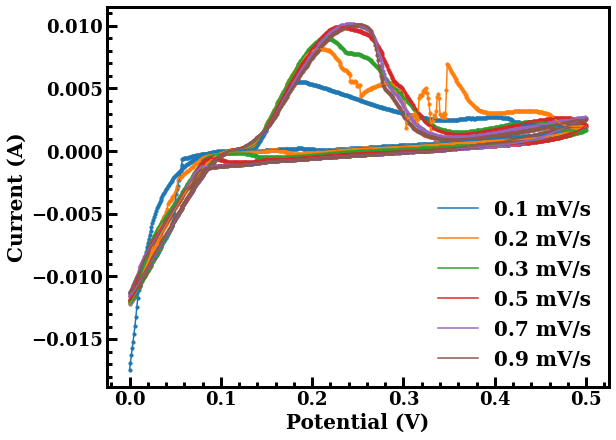

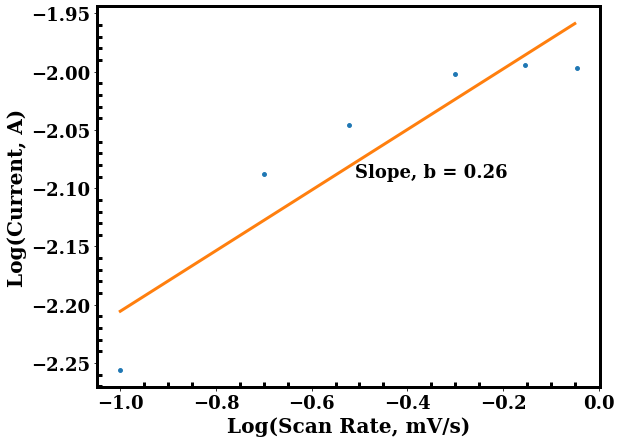

Voltage Step Size for k1,k2 Calculation:
0.001


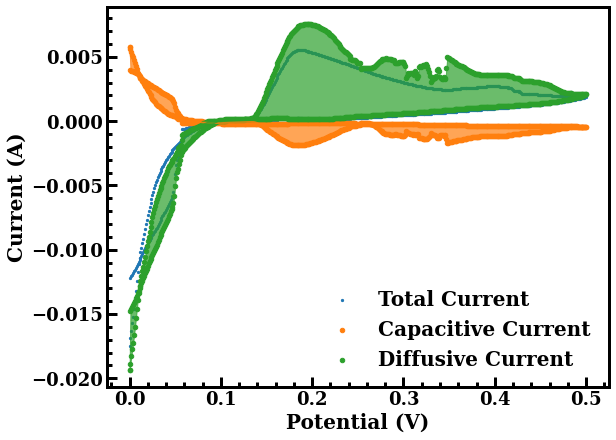

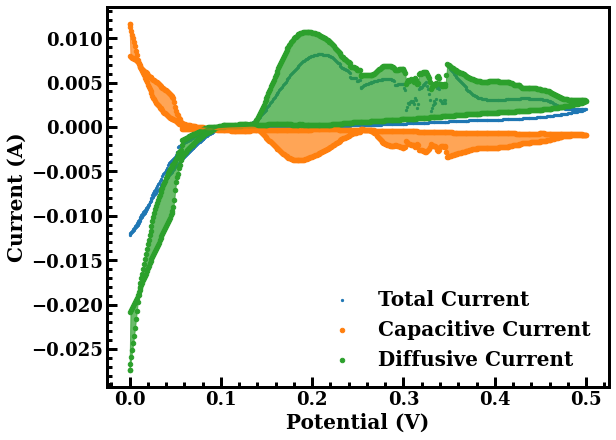

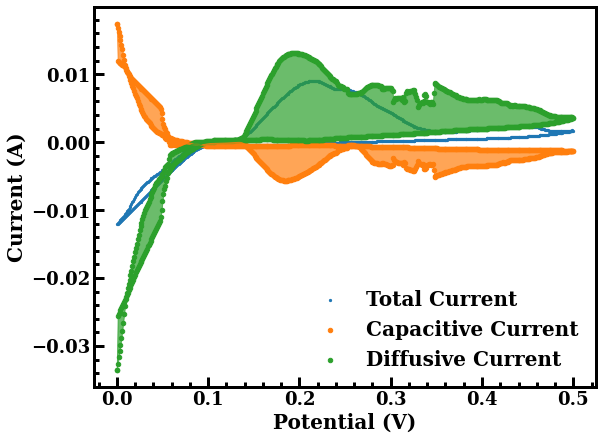

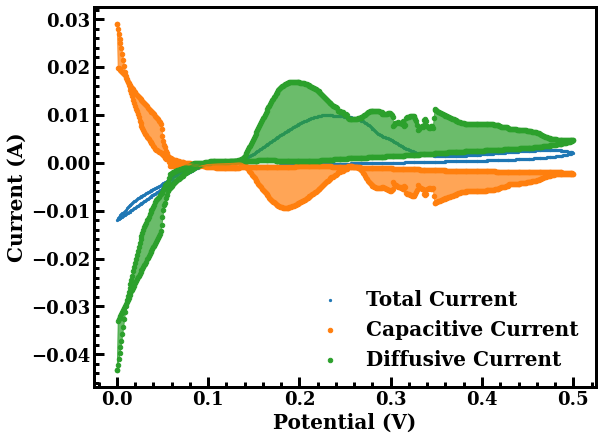

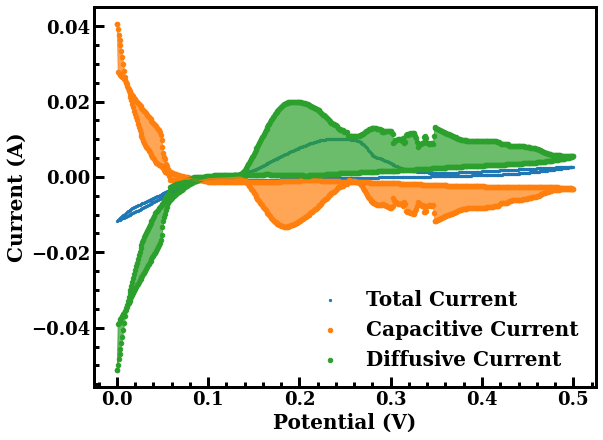

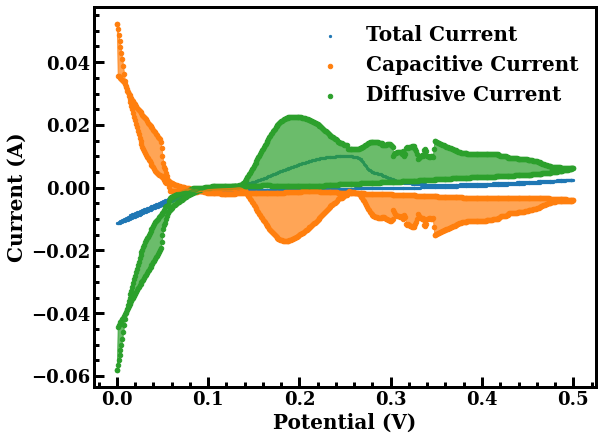

<Figure size 648x504 with 0 Axes>

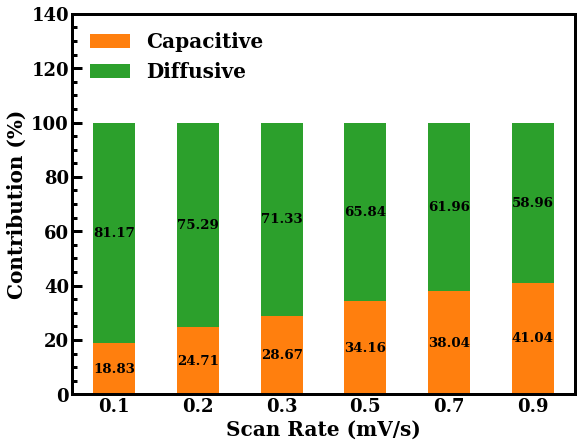

In [13]:
__author__ = "Baibhav Srivastava"
__copyright__ = "Copyright (C) 2022 Baibhav Srivastava"
__license__ = "Public Domain"
__version__ = "1.0"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (9,7)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.linewidth"] = 3
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
cmap = plt.get_cmap('tab10') 

def CV():
    
    ticklabelsize = 18
    labelsize = 20
    tick_direction = 'in'
    tick_length = 10
    tick_width = 3    
    markersize = 12
    
    more_files = True
    data = []
    rates = []
    while more_files == True:
        name = input("Enter the name of the file: \n")
        dat = np.loadtxt(f"{str(name)}.txt", dtype = float, delimiter = ',', skiprows = 16)
        data.append(dat)
        rate = input("Enter the Scan Rate \n")
        rates.append(float(rate))
        more_files = input("Do you want to upload more files? \n")
        more_files = bool(int(more_files))
    
    cv_file_name = input("Name of the Output File: \n")
    
    with open(f'{str(cv_file_name)}.txt', 'w') as f:
        f.write("CV ANALYSIS\n\n")
        f.write(f"Scan Rates Under Consideration: {rates} mV/s\n")
        f.write("--"*60+"\n")
    
    fig = plt.figure()
    for i in range(0, len(rates)):
        plt.scatter(data[i].T[0],data[i].T[1], s = 10, color = cmap(i))
        plt.plot(data[i].T[0],data[i].T[1], linestyle = None, label = f"{rates[i]} mV/s", color = cmap(i))
    plt.xlabel("Potential (V)", fontweight="bold", fontsize = labelsize)
    plt.ylabel("Current (A)", fontweight="bold", fontsize = labelsize)
    plt.legend(frameon=False,prop={'size': 20})
    plt.grid(False)
    plt.minorticks_on()
    plt.tick_params(which = 'major', direction = tick_direction, width = tick_width, length = tick_length)
    plt.tick_params(which = 'minor', direction = tick_direction, width = tick_width, length = tick_length/2)
    plt.yticks(fontsize = ticklabelsize)
    plt.xticks(fontsize = ticklabelsize)
    plt.savefig("CV.jpg", dpi = 600, bbox_inches = 'tight')
    plt.show()  
    
    peaks = []
    for arr in data:
        peaks.append(arr.T[1].max())
    peaks = np.array(peaks)

    log_peaks = np.log10(peaks)
    log_rate = np.log10(rates)
    
    fig = plt.figure()
    #plt.title(r"Log $\mathbf{I_p}$ vs $\mathbf{\nu}$", fontweight="bold")
    plt.scatter(log_rate,log_peaks, s = 15)
    
    coeff = np.polyfit(log_rate,log_peaks, 1)
    x = np.arange(log_rate[0],log_rate[-1],0.01)
    y = coeff[0]*x + coeff[1]
    
    plt.plot(x,y, color = cmap(1),  linewidth = 3)
    plt.text(x[int(len(x)/2)] + 0.01, y[int(len(y)/2)]-0.01, f"Slope, b = {np.round(coeff[0],3)}", 
             fontsize = ticklabelsize )
    plt.xlabel(r'Log(Scan Rate, mV/s)', fontweight="bold", fontsize = labelsize)
    plt.ylabel(r'Log(Current, A)', fontweight="bold", fontsize = labelsize)
    #plt.legend(frameon=False)
    plt.grid(False)
    plt.xticks(weight = 'bold')
    plt.yticks(weight = 'bold')
    plt.minorticks_on()
    plt.tick_params(which = 'minor', direction = tick_direction, width = tick_width, length = tick_length/2)
    plt.yticks(fontsize = ticklabelsize)
    plt.xticks(fontsize = ticklabelsize)
    plt.savefig("Fit.jpg", dpi = 600, bbox_inches = 'tight')
    plt.show()
    
    with open(f'{str(cv_file_name)}.txt', 'a') as f:
        f.write(f"\nSlope of the Line for Log I_p vs Log Scan Rate: {coeff[0]}\n")
        f.write("\n"+"--"*60+"\n")
    
    h = input("Voltage Step Size for k1,k2 Calculation:\n")
    h = float(h)
    
    v = np.round(np.arange(0,0.5+h,h),3)
    I_lower = []
    I_upper = []
    I_corner = []
    
    for pt in v:
        i_low = []
        i_high = []
        i_cor = []
        for arr in data:
            if len(arr.T[1][np.where(arr.T[0]==pt)])>1:
                i1 = min(arr.T[1][np.where(arr.T[0]==pt)])
                i2 = max(arr.T[1][np.where(arr.T[0]==pt)])
                i_low.append(i1)
                i_high.append(i2)
            if (len(arr.T[1][np.where(arr.T[0]==pt)])>0 & len(arr.T[1][np.where(arr.T[0]==pt)])<2):
                i0 = arr.T[1][np.where(arr.T[0]==pt)][0]
                i_cor.append(i0)
        if len(i_low) > 0:
            I_lower.append(i_low)
        if len(i_high) > 0:
            I_upper.append(i_high)
        if len(i_cor) > 0:
            I_corner.append(i_cor)
    
    C_high = []
    C_low = []
    C_cor = []
    
    for i in range(0,len(I_lower)):
        coeffs_low = np.polyfit(np.sqrt(rates), I_lower[i]/np.sqrt(rates),1)
        C_low.append(coeffs_low)
                  
    for i in range(0,len(I_upper)):
        coeffs_high = np.polyfit(np.sqrt(rates), I_upper[i]/np.sqrt(rates),1)
        C_high.append(coeffs_high)
                    
    for i in range(0,len(I_corner)):
        coeffs_cor = np.polyfit(np.sqrt(rates), I_corner[i]/np.sqrt(rates),1)
        C_cor.append(coeffs_cor)
    
    C_high = np.array(C_high)
    C_low = np.array(C_low)
    C_cor = np.array(C_cor)
    
    k1_low = C_low.T[0]
    k2_low = C_low.T[1]
    
    k1_high = C_high.T[0]
    k2_high = C_high.T[1]
    
    k1_cor = C_cor.T[0]
    k2_cor = C_cor.T[1]
    
    with open(f'{str(cv_file_name)}.txt', 'a') as f:
        f.write("\nValues of k1 and k2 for Different Voltages:\n\n")
        f.write("Voltage\tk1(lower)\tk2(lower)\tk1(upper)\tk2(upper)\n")
        for i in range(1,len(v)-1):
            f.write(f"{v[i]}\t{k1_low[i-1]}\t{k2_low[i-1]}\t{k1_high[i-1]}\t{k2_high[i-1]}\n")
        f.write("\n"+"--"*60+"\n")
    
    contri_dif = []
    contri_cap = []
    
    with open(f'{str(cv_file_name)}.txt', 'a') as f:
        f.write("\nValues for Capacitive and Diffusive Contributions:\n")
    
    for i in range(len(rates)):
        i_cap_low = k1_low*rates[i]
        i_cap_high = k1_high*rates[i]
        i_cap_cor = k1_cor*rates[i]
        
        i_cap_low = np.insert(i_cap_low, 0, i_cap_cor[0])
        i_cap_low = np.append(i_cap_low, i_cap_cor[-1])
        
        i_cap_high = np.insert(i_cap_high, 0, i_cap_cor[0])
        i_cap_high = np.append(i_cap_high, i_cap_cor[-1])
        
        i_dif_low = k2_low*np.sqrt(rates[i])
        i_dif_high = k2_high*np.sqrt(rates[i])
        i_dif_cor = k2_cor*np.sqrt(rates[i])
        
        i_dif_low = np.insert(i_dif_low, 0, i_dif_cor[0])
        i_dif_low = np.append(i_dif_low, i_dif_cor[-1])
        
        i_dif_high = np.insert(i_dif_high, 0, i_dif_cor[0])
        i_dif_high = np.append(i_dif_high, i_dif_cor[-1])
        
        with open(f'{str(cv_file_name)}.txt', 'a') as f:
            f.write(f"\nFor Scan Rate {rates[i]} mV/s:\n")
            f.write(f"\nVoltage\tCapacitive Current (Upper)\tCapacitive Current (Lower)\tDiffusive Current (Upper)\tDiffusive Current (Lower)\n")
            for j in range(len(v)):
                f.write(f"{v[j]}\t{i_cap_high[j]}\t{i_cap_low[j]}\t{i_dif_high[j]}\t{i_dif_low[j]}\n")
            
        area_dif = np.trapz(abs(i_dif_high - i_dif_low))
        area_cap = np.trapz(abs(i_cap_high - i_cap_low))
        
        contri_dif.append(area_dif/(area_dif+area_cap)*100)
        contri_cap.append(area_cap/(area_dif+area_cap)*100)
        
        fig = plt.figure()
        #plt.title(r"$\mathbf{\nu =}$ "+f"{rates[i]}", fontweight="bold")
        
        plt.scatter(data[i].T[0],data[i].T[1], s = 5, label = "Total Current")
        
        plt.scatter(v, i_cap_low, color = cmap(1), s = 20, label = "Capacitive Current")
        plt.scatter(v, i_cap_high, color = cmap(1), s = 20)

        plt.scatter(v, i_dif_low, color = cmap(2), s = 20, label = "Diffusive Current")
        plt.scatter(v, i_dif_high, color = cmap(2), s = 20)
        
        plt.fill_between(v, i_cap_high, i_cap_low, color = cmap(1), alpha = 0.7)
        plt.fill_between(v, i_dif_high, i_dif_low, color = cmap(2), alpha = 0.7)
    
        plt.legend(frameon=False, prop={'size': 20})
        plt.xlabel("Potential (V)", fontweight="bold", fontsize = labelsize)
        plt.ylabel("Current (A)", fontweight="bold", fontsize = labelsize)
        plt.grid(False)
        plt.minorticks_on()
        plt.tick_params(which = 'major', direction = tick_direction, width = tick_width, length = tick_length)
        plt.tick_params(which = 'minor', direction = tick_direction, width = tick_width, length = tick_length/2)
        plt.yticks(fontsize = ticklabelsize)
        plt.xticks(fontsize = ticklabelsize)
        plt.savefig(f"Contributions_{rates[i]}mVs.jpg", dpi = 600, bbox_inches = 'tight')
        plt.show()
    
    contri_cap = np.array(contri_cap)
    contri_dif = np.array(contri_dif)
    
    with open(f'{str(cv_file_name)}.txt', 'a') as f:
        f.write("\nPercentage Contribution:\n")
        for i in range(len(rates)):
            f.write(f"For Scan Rate {rates[i]} mV/s: ")
            f.write(f"Diffusive: {contri_dif[i]}%\tCapacitive: {contri_cap[i]}%\n")
    
    df = pd.DataFrame(data = {'Capacitive':contri_cap, 'Diffusive':contri_dif})
    df.index = rates
    
    fig = plt.figure()
    plt.rcParams.update({'font.weight': 'bold'})
    ax = df.plot(kind = 'bar', stacked = True, rot = 0, color = [cmap(1), cmap(2)])
    for c in ax.containers:
        labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels = np.round(labels,2), label_type = 'center', fontsize = labelsize/1.5)
    #ax.legend(bbox_to_anchor=(1.04,0.1), loc="lower left")
    ax.legend(loc = 'upper left', frameon=False, prop={'size': 20})
    plt.ylim(0,140)
    plt.grid(False)
    plt.xlabel("Scan Rate (mV/s)", fontweight = 'bold', fontsize = labelsize)
    plt.ylabel("Contribution (%)", fontweight = 'bold', fontsize = labelsize)
    plt.xticks(weight = 'bold', fontsize = ticklabelsize)
    plt.yticks(weight = 'bold', fontsize = ticklabelsize)
    plt.minorticks_on()
    plt.tick_params(which = 'major', direction = tick_direction, width = tick_width, length = tick_length)
    plt.tick_params(which = 'minor', direction = tick_direction, width = tick_width, length = tick_length/2)
    plt.tick_params(axis = 'x', which = 'both', length = 0)
    plt.yticks(fontsize = ticklabelsize)
    plt.savefig("Contribution_Histrogram.jpg", dpi = 600, bbox_inches = 'tight')
    plt.show()
    
#     areas = []
#     for arr in data:
#         iup = arr.T[1][0:501]
#         idown = arr.T[1][500:1000]
#         idown = np.append(idown, arr.T[1][0])
#         idown = idown[::-1]
#         ar = np.trapz(abs(iup - idown))
#         areas.append(ar)
CV()